# Уровень удовлетворенности сотрудников

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников.

Компания предоставила данные с характеристиками сотрудников компании. Среди них — уровень удовлетворённости сотрудника работой в компании. Эту информацию получили из форм обратной связи: сотрудники заполняют тест-опросник, и по его результатам рассчитывается доля их удовлетворённости от 0 до 1, где 0 — совершенно неудовлетворён, 1 — полностью удовлетворён. 

**Задачи:**
1. построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика.
2. построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.
<br><br>

**Предоставленные данные:** \
***I задача:***
- Тренировочная выборка: `train_job_satisfaction_rate.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_job_satisfaction_rate.csv`

***II задача:***
- Тренировочная выборка: `train_quit.csv`
- Входные признаки тестовой выборки: `test_features.csv`
- Целевой признак тестовой выборки: `test_target_quit.csv` 
<br><br>

**Описание данных:**
- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании (**целевой признак для первой задачи**);
- `quit` — увольнение сотрудника из компании (**целевой признак для второй задачи**).
<br><br>

**Основные этапы работ для каждой из задач:**
1. Изучение и предобработка данных.
2. Исследовательский и корреляционный анализ.
3. Подготовка данных
4. Обучение нескольких моделей и выбор лучшей.

## Библиотеки и функции

In [1]:
# !pip install phik -q
# !pip install shap -q
# !pip install -U scikit-learn -q
# !pip install matplotlib==3.5.1 -q

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.preprocessing import (
    StandardScaler, 
    OneHotEncoder,
    OrdinalEncoder, 
    LabelEncoder
)

from sklearn.metrics import make_scorer, roc_auc_score 


sns.set_style('darkgrid')
pd.set_option('display.max_columns', None) # Отображение неограниченного количества столбцов в таблицах
pd.set_option('display.max_colwidth', None)  # Снятие ограничения на максимальную длину строки в таблице
#pd.set_option('display.max_rows', None) # Отображение неограниченного количества строк в таблица

# Константы
RANDOM_STATE = 42

In [6]:
# Функция для отрисовки круговых диаграмм
def chart_pie(data, col, ax, title=None, sort=False):
    x = data.groupby(col)[col].count()
    
    if sort:
        x = x.sort_values(ascending=False)
    if not title:
        title = col
        
    ax.pie(
        x=x,
        labels=x.index,
        autopct='%.1f%%', 
        startangle = 90,
        pctdistance=.8, 
        wedgeprops={'width': .4}, 
        colors=sns.color_palette('pastel')
    )
    ax.text(
        0, 0, title, #.replace('_', '\n'), 
        horizontalalignment='center', 
        verticalalignment='center', 
        fontweight='bold',
        fontsize = 10
    )
    ax.set(title='', xlabel='', ylabel='')

In [7]:
# Функция для отрисовки пары boxplot и histplot
def chart_box_hist(data, columns, title=None, bins=30, hue=None):
    s = len(columns)
    fig = plt.subplots(s, 2, figsize=(12, s * 3.5))
    plt.suptitle(title, fontsize=14, fontweight='bold')
    for i, col in zip(range(1, s + 1), columns):
        data_group_shape = data.groupby(col)[col].count().shape[0]
        bins_ = bins if data_group_shape >= bins else data_group_shape

        ax1 = plt.subplot(s, 2, i*2 - 1)
        ax2 = plt.subplot(s, 2, i*2)

        sns.boxplot(data=data, x=col, y=hue, boxprops={'alpha': .6}, ax=ax1)
        ax1.set(title=col, xlabel='', ylabel='')
        sns.histplot(data=data, x=col, hue=hue, kde=True, bins=bins_, ax=ax2, legend=True, multiple="stack", stat='density', common_norm=False)
        ax2.set(title=col, xlabel='', ylabel='')

        if not hue:
            df = data[col]
            ax2.axvline(x=df.median(), color='black', alpha=.6, label=f'median ({df.median():.2f})')
            ax2.axvline(x=df.mean(),   color='black', alpha=.6, label=f'mean ({df.mean():.2f})', linestyle='dashed')
        else:
            for i, hu in enumerate(data[hue].unique()):
                df = data[data[hue] == hu][col]
                ax2.axvline(x=df.mean(), alpha=1, linewidth=1.5, color=plt.cm.tab10.colors[i], label=f'mean {hue} - {hu} ({df.mean():.2f})', linestyle='dashed')
                
        ax2.legend(bbox_to_anchor=(1.05 , 1), loc='upper left', borderaxespad=0)
    plt.show()

In [8]:
# Функция для вывода матрицы корреляции
def corr_matrix(phik_overview):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(phik_overview, annot=True, fmt='.2f', cmap='Blues', ax=ax)
    ax.set_title('correlation $\phi_K$', fontsize=14, fontweight='bold')
    plt.show()

In [9]:
# Функция для вывода отсортированной таблицы коэффициентов корреляции
def corr_sort(data):
    result = (
        data
        .abs()
        .stack()
        .reset_index()
        .rename(columns={0: "corr", 'level_0': 'feature_1', 'level_1': 'feature_2'})
        .query('feature_1 != feature_2')
        .sort_values(by='corr', ascending=False)
        .loc[::2]
        .reset_index(drop=True)
    )
    return result

In [10]:
# Функция для вывода коэффициентов и степени корреляции целевого признака
def target_corr(phik_overview, col):
    def corr_relation(coef):
        try:
            if coef < 0.1:
                return 'осутствует'
            elif 0.1 <= coef < 0.3:
                return 'слабая'
            elif 0.3 <= coef < 0.5:
                return 'умеренная'
            elif 0.5 <= coef < 0.7:
                return 'заметная'
            elif 0.7 <= coef < 0.9:
                return 'высокая'
            elif 0.9 <= coef < 0.95:
                return 'весьма высокая'
            else:
                return 'наблюдается мультиколлинеарность'
        except:
            pass
    
    target_corr = pd.DataFrame(phik_overview[col].abs().drop(col).sort_values(ascending=False))
    target_corr.columns = ['коэффициент корреляции']
    target_corr['тип связи'] = target_corr['коэффициент корреляции'].apply(corr_relation)
    return target_corr

In [11]:
# Функция для формирования таблицы лучших моделей после автоматизированного поиска
def cv_results_best(search, negative=False):
    results = pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']]
    results.mean_test_score = results.mean_test_score * (-1 if negative else 1)
    return results.sort_values('rank_test_score').set_index('rank_test_score')

## **Задача 1: предсказание уровня удовлетворённости сотрудника**

### Загрузка данных

In [12]:
train_sat = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
X_test_sat = pd.read_csv('/datasets/test_features.csv')
y_test_sat = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')


df_list_1 = [train_sat, X_test_sat, y_test_sat]
df_name_1 = ['train_sat', 'X_test_sat', 'y_test_sat']

Вывод первых строк каждой из таблиц и общей информации о данных:

In [13]:
for df, df_name in zip(df_list_1, df_name_1):
    print(f'{df_name}:')
    display(df.head())
    df.info()
    print('\n')

train_sat:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


X_test_sat:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


y_test_sat:


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB




Проверка наличия пропусков в данных:

In [14]:
for df, df_name in zip(df_list_1, df_name_1):
    print(f'{df_name}:')
    x = df.isna().sum()[df.isna().sum() > 0]
    print('Пропусков нет' if len(x) == 0 else x, '\n')

train_sat:
dept     6
level    4
dtype: int64 

X_test_sat:
dept     2
level    1
dtype: int64 

y_test_sat:
Пропусков нет 



**Вывод:** данные в таблицах соответствуют описанию. Тип данных всех признаков выставлен корректный. Имеется несколько пропусков в колонках dept и level - заполним их в пайплайне во время подготовки данных. \
Значения в X_test_sat и y_test_sat не упорядочены по id, количество строк в датафреймах совпадает. Хорошим решением будет объединить датафреймы по колонке id.

### Предобработка данных

#### Проверка наличия неявных дубликатов

In [15]:
for df, df_name in zip(df_list_1, df_name_1):
    print(f'{df_name}:')
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    for col in cat_col_names:
        print(f'{col}:', df[col].unique())
    print() 

train_sat:
dept: ['sales' 'hr' 'technology' 'purchasing' 'marketing' nan]
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'high' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']

X_test_sat:
dept: ['marketing' 'hr' 'sales' 'purchasing' 'technology' nan ' ']
level: ['junior' 'middle' 'sinior' nan]
workload: ['medium' 'low' 'high' ' ']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']

y_test_sat:



Во втором датасете **X_test_sat** в колонках `dept` и `workload` присутствуют значения с содержащие только один пробел; проверим, сколько их

In [16]:
X_test_sat.query('dept == " " or workload == " "')

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
15,590867,marketing,junior,,4,no,no,4,28800
1699,822186,,middle,medium,3,no,no,4,38400


**Вывод:** две строки с пробелом вместо значения - данные пропуски обработаются в пайплайне.

#### Проверка наличия явных дубликатов

Проверим наличие явных дубликатов в данных:

In [17]:
for i, j in zip(df_list_1, df_name_1):
    print(f'{df_name}:', df.duplicated().sum())

y_test_sat: 0
y_test_sat: 0
y_test_sat: 0


Проверим, есть ли в таблицах дубликаты id:

In [18]:
for df, df_name in zip(df_list_1, df_name_1):
    print(f'{df_name}:', df['id'].duplicated().sum())

train_sat: 0
X_test_sat: 0
y_test_sat: 0


**Вывод:** явных дубликатов в данных нет.

#### Объединение таблиц **X_test_sat** и **y_test_sat**

В датафреймах X_test_sat и y_test_sat значения идут в разном порядке (не упорядочены по id). Объединим таблицы по столбцу `id` методом **inner** и убедимся, что количество строк осталось прежним, т.е. 2000. \
Для начала в качестве индекса установим столбец id во всех датафреймах.

In [19]:
for df in df_list_1:
    df.set_index('id', inplace=True)
    # проверяем результат
    display(df.head(1))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800


,job_satisfaction_rate
id,
130604,0.74


In [20]:
test_sat = X_test_sat.join(y_test_sat, how='inner')
# проверяем результат
display(test_sat.head())
test_sat.shape

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.79
686555,hr,junior,medium,1,no,no,4,30000,0.72
467458,sales,middle,low,5,no,no,4,19200,0.64
418655,sales,middle,low,6,no,no,4,19200,0.60
789145,hr,middle,medium,5,no,no,5,40800,0.75


(2000, 9)

**Вывод:** во всех таблицах в качестве индекса установлен столбец id. Объединение X_test_sat и y_test_sat успешно осуществлено. Количество строк равно 2000, как и в исходных таблицах, т.е. непересекающихся значений в данных небыло.

In [21]:
# обновим список датафреймов
df_list_1 = [train_sat, test_sat]
df_name_1 = ['train_sat', 'test_sat']

Вновь проверим данные на наличие явных дубликатов при отсутствие столбца `id`

In [22]:
for df, df_name in zip(df_list_1, df_name_1):
    print(f'{df_name}:', df.duplicated().sum())

train_sat: 245
test_sat: 83


**Вывод:** в обоих датафреймах есть дубликаты. В тестовой выборке они нам не помешают. Но в тренировочных данных перед обучением модели мы от них избавимся, что бы модель не делала акцент на этих дублирующихся значениях.

### Исследовательский анализ данных

Описательная статистика числовых данных

In [23]:
for df, df_name in zip(df_list_1, df_name_1):
    print(f'{df_name}:')
    display(df.describe())
    print()

train_sat:


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000



test_sat:


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,2000.000000,2000.000000,2000.000000,2000.00000
mean,3.666500,3.526500,34066.800000,0.54878
std,2.537222,0.996892,15398.436729,0.22011
min,1.000000,1.000000,12000.000000,0.03000
25%,1.000000,3.000000,22800.000000,0.38000
50%,3.000000,4.000000,30000.000000,0.58000
75%,6.000000,4.000000,43200.000000,0.72000
max,10.000000,5.000000,96000.000000,1.00000


**Вывод:** явных выбросов и аномалий в данных не наблюдается. Распределения значений в тестовой и тренировочной выборках довольно похожи, что говорит об однородности данных.

#### Распределение числовых признаков

Рассмотрим, как распределены значения числовых признаков в тренировочном и тестовом датафремах.

In [24]:
# Сформируем списки с числовыми и категориальными признаками
num_col = train_sat.select_dtypes(include='number').columns.tolist()
cat_col = train_sat.select_dtypes(include='object').columns.tolist()

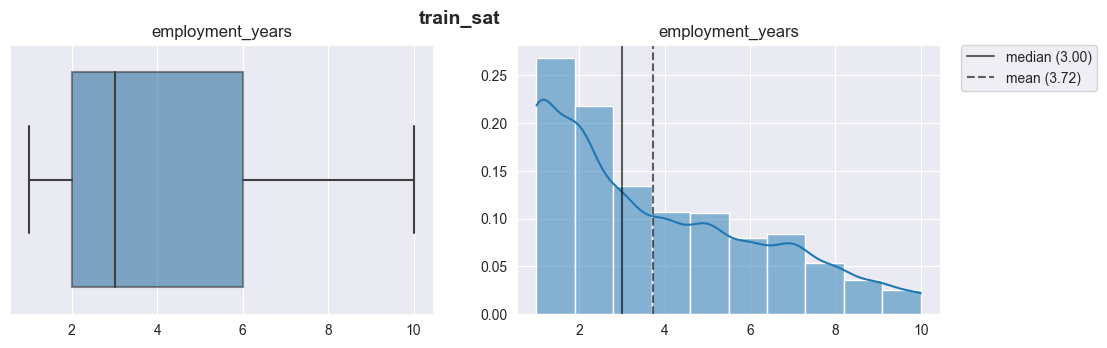

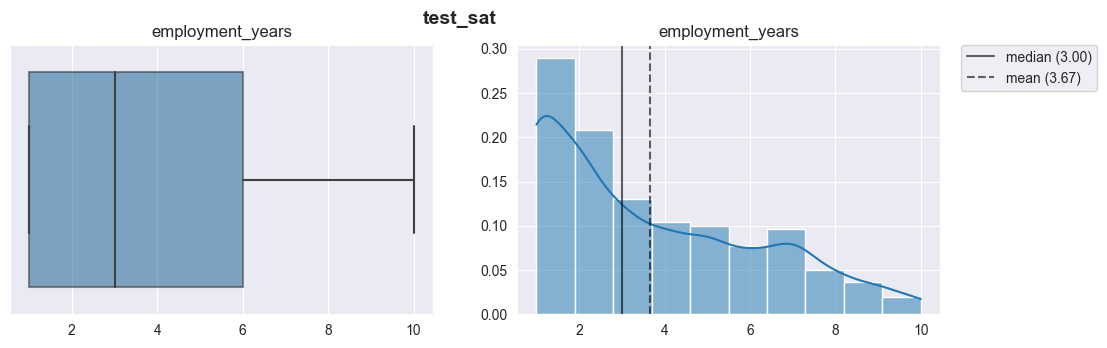

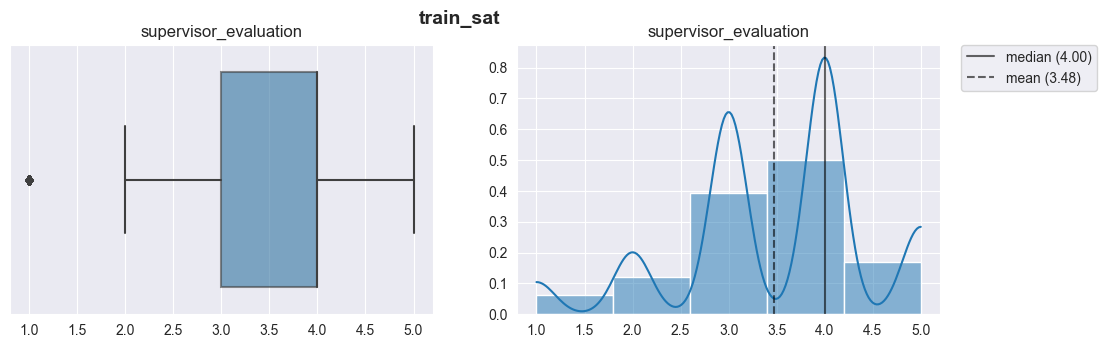

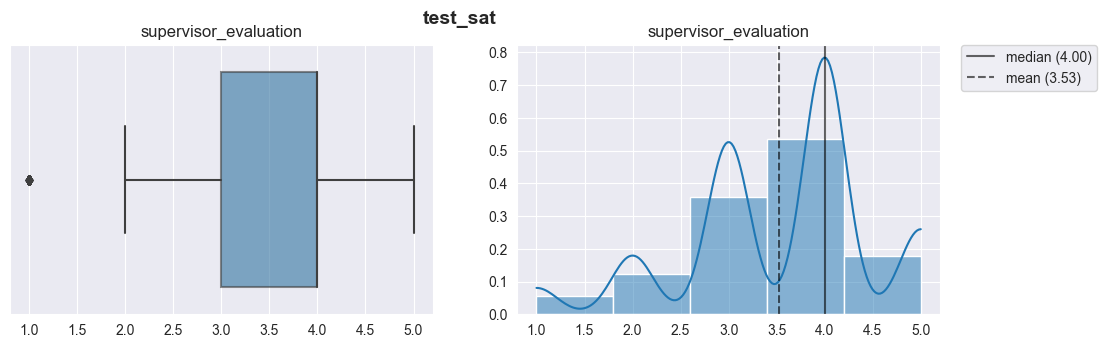

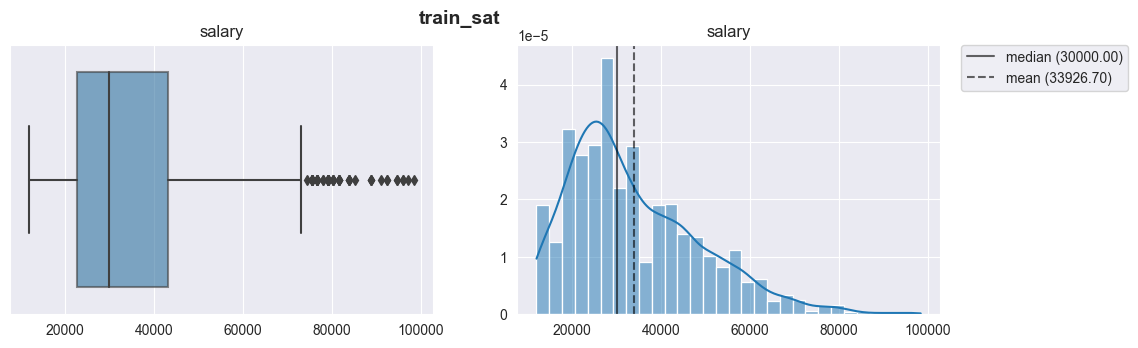

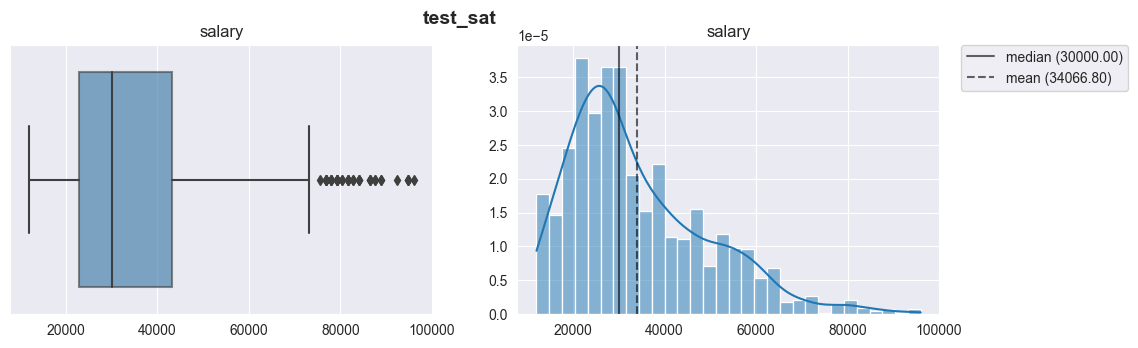

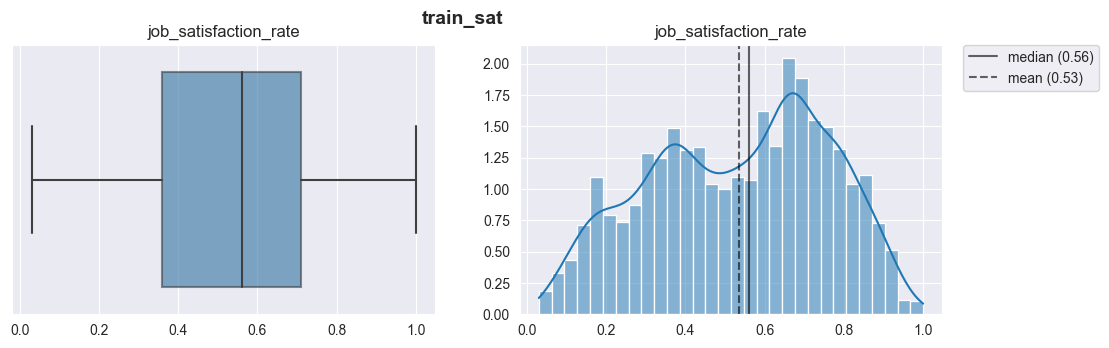

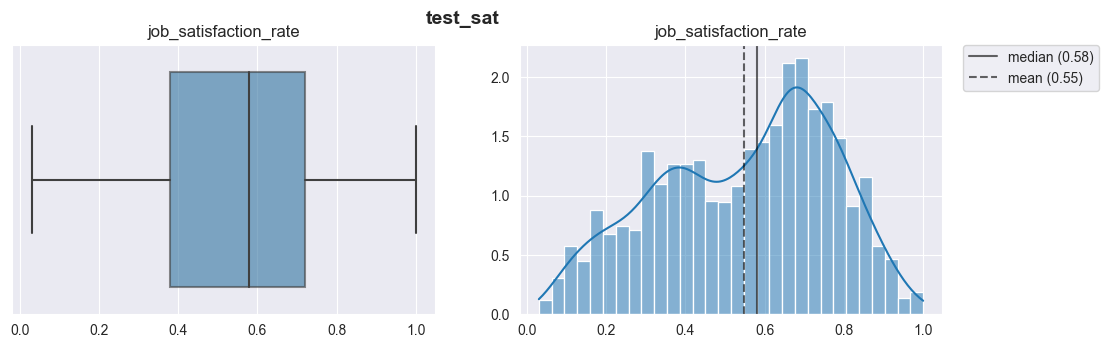

In [25]:
for col in num_col:
    for df, df_name in zip(df_list_1, df_name_1):
        chart_box_hist(df, [col], f'{df_name}')
    print('\n\n\n')

**Вывод:** графики подтверждают схожесть распределения значений в тренировочной и тестовой выборке. \
- средняя длительность работы в компании составляет примерно **3 года и 8 месяцев**.
- средняя оценка качества работы сотрудника, которую дал руководитель, равна примерно **3.5**.
- график `salary` похож на нормальное распределение со смещением влево. Это говорит о том, что в выборке присутствует небольшое количество высокооплачиваемых сотрудников, получающих ЗП сильно выше средней. Средняя ЗП находится в районе **34000**.
- распределение целевого признака `job_satisfaction_rate` напоминает бимодальное распределение с пиками в районе 0.4 и 0.65. Среднее значение равно примерно **0.54**.

#### Распределение категориальных признаков

Теперь рассмотрим распределения категориальных признаков

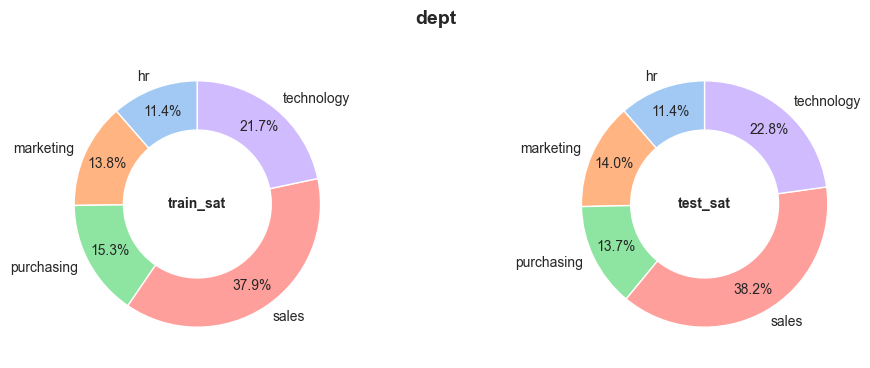

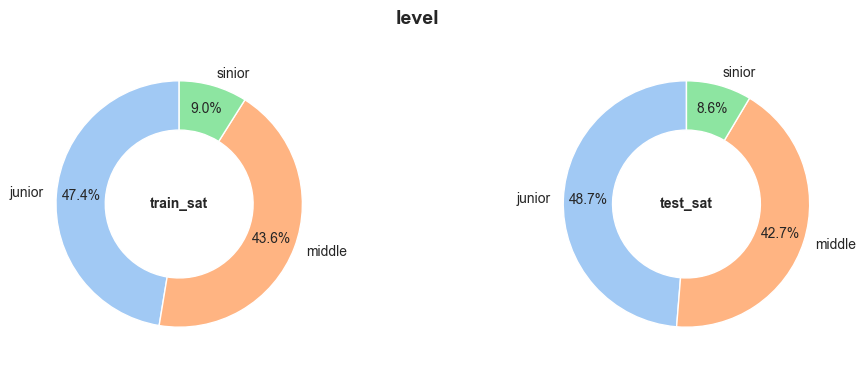

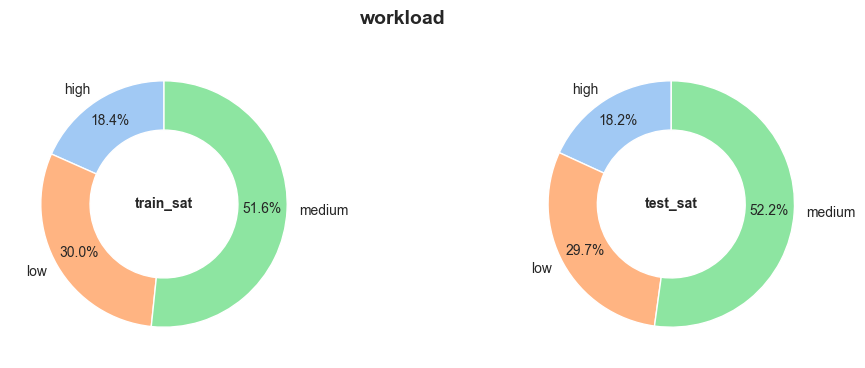

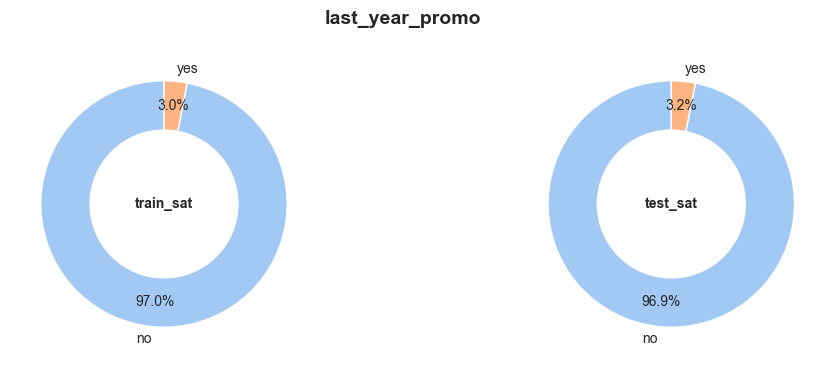

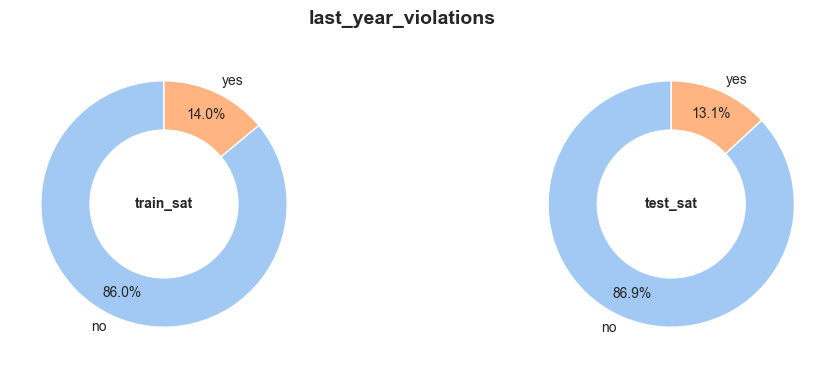

In [26]:
for col in cat_col:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plt.suptitle(col, fontsize=14, fontweight='bold')
    for df, df_name, ax in zip(df_list_1, df_name_1, axes):
        chart_pie(df[df[col] != ' '], col, ax, title=df_name)
    plt.show()
    print('\n')

**Вывод:** распределения категориальных признаков в двух выборках так же довольно схожи.
- примерно **38%** сотрудников компании работает в отделе продаж
- почти половина занимаемых должностей приходится на джуниуров; около **9%** на синьеров.
- **более половины** всех сотрудников имеют среднюю загруженность.
- повышение за последний год было только у **3%** сотрудников.
- за последний год трудовой договор нарушило примерно **13-14%** сотрудников.

#### Корреляционный анализ

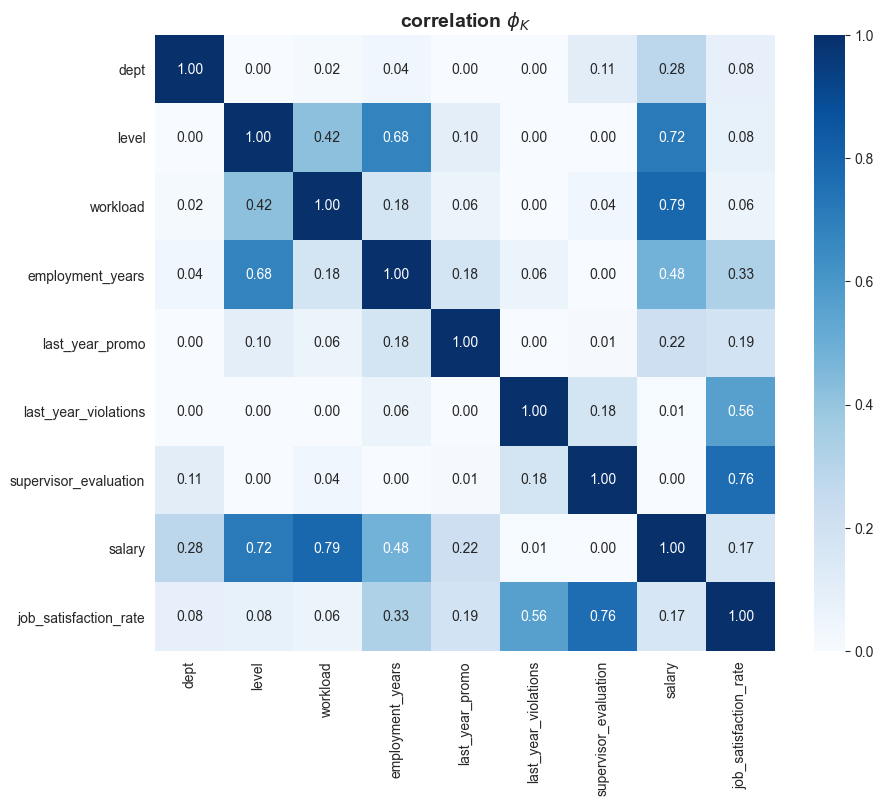

Наибольшие коэффициенты корреляции:


,feature_1,feature_2,corr
0,workload,salary,0.788820
1,job_satisfaction_rate,supervisor_evaluation,0.764364
2,salary,level,0.717630
3,employment_years,level,0.682773
4,job_satisfaction_rate,last_year_violations,0.560348
5,employment_years,salary,0.483419
6,level,workload,0.419114
7,job_satisfaction_rate,employment_years,0.325603
8,dept,salary,0.282265
9,salary,last_year_promo,0.215025


In [27]:
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate']
phik_overview = train_sat.phik_matrix(interval_cols=interval_cols)

corr_matrix(phik_overview)

print('Наибольшие коэффициенты корреляции:')
corr_sort(phik_overview).head(10)

Рассмотрим отдельно корреляцию целевого признака

In [28]:
target_corr(phik_overview, 'job_satisfaction_rate')

,коэффициент корреляции,тип связи
supervisor_evaluation,0.764364,высокая
last_year_violations,0.560348,заметная
employment_years,0.325603,умеренная
last_year_promo,0.190803,слабая
salary,0.165830,слабая
dept,0.082086,осутствует
level,0.080620,осутствует
workload,0.056128,осутствует


**Вывод:** мультиколлинеорность у признаков отсутствует (коэффициент выше 0.95). \
Таргет `job_satisfaction_rate` имеет наибольшую взаимосвязь с такими признаками, как `supervisor_evaluation`, `last_year_violations` и `employment_years`.

### Подготовка данных

В тренировочном датасете удалим дубликаты строк, что бы модель не усиливала взаимосвязи, присущие дублирующимся строкам.

In [29]:
print('Количество дубликатов в train_sat:', train_sat.duplicated().sum())

rows_before = train_sat.shape[0]

train_sat.drop_duplicates(inplace=True)

# проверка
print('Количество удаленных строк:', rows_before - train_sat.shape[0])

Количество дубликатов в train_sat: 245
Количество удаленных строк: 245


245 дубликатов успешно удалены.

In [30]:
print('Размеры исходных датафреймов:')
print(f'train_sat: {train_sat.shape}')
print(f'test_sat: {test_sat.shape}')

Размеры исходных датафреймов:
train_sat: (3755, 9)
test_sat: (2000, 9)


Каждый датафрейм разделим на два, отделив таргет

In [31]:
target = 'job_satisfaction_rate'

X_train = train_sat.drop(target, axis=1)
y_train = train_sat[target]

X_test = test_sat.drop(target, axis=1)
y_test = test_sat[target]

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation']

print('Размеры датафреймов после отделения таргета:')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

Размеры датафреймов после отделения таргета:
X_train: (3755, 8), y_train: (3755,)
X_test: (2000, 8), y_test: (2000,)


**Вывод:** данные успешно подготовлены. Количество элементов в разделенных датафремах в сумме совпадает с количеством в исходных.

In [32]:
# Функция для формирования пайплайна
def pipline_final(ohe_columns, ord_columns, num_columns):
    ohe_pipe = Pipeline([
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False))
    ])
    
    
    ord_pipe = Pipeline([
        ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ord',  OrdinalEncoder(
            categories=[
                ['junior', 'middle', 'sinior'],
                ['low', 'medium', 'high']
            ], 
            handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
        ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ])
    
    
    
    data_preprocessor = ColumnTransformer([
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns),
    ], 
    # remainder='passthrough'
    )
    
    
    
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', None)
    ])

    return pipe_final

In [33]:
# Функция для расчета метрики SMAPE
def smape(y_true, y_pred):
    result = 100 * np.mean(np.abs(y_pred - y_true) / ((np.abs(y_pred) + np.abs(y_true))/2))
    return result

smape_score = make_scorer(smape, greater_is_better=False)

### Обучение моделей

Наш целевой признак - количественных, поэтому для обучения будем использовать несколько моделей регрессии - **LinearRegression**, **DecisionTreeRegressor**, **KNeighborsRegressor**.

In [34]:
param_grid = [
    {
        'models': [LinearRegression()]
    },
    
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15)
    },

    {
        'models': [KNeighborsRegressor()],
        'models__n_neighbors': range(2, 20)
    }
 
]


randomized_search_1 = RandomizedSearchCV(
    pipline_final(ohe_columns, ord_columns, num_columns), 
    param_grid, 
    cv=5,
    scoring=smape_score,
    n_jobs=-1, 
    random_state=RANDOM_STATE,
    n_iter=50
)

# Обучаем лучшую модель на тренировочных данных
randomized_search_1.fit(X_train, y_train)


print(f'Лучшая модель и её параметры:\n {randomized_search_1.best_params_}')
print(f'Метрика SMAPE на тренировочной выборке: {randomized_search_1.best_score_ * -1:.3f}')

y_test_pred = randomized_search_1.best_estimator_.predict(X_test)
smape_test = smape(y_test, y_test_pred)
print(f'Метрика SMAPE на тестовой выборке: {smape_test:.3f}')

Лучшая модель и её параметры:
 {'models__max_features': 13, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}
Метрика SMAPE на тренировочной выборке: 15.797
Метрика SMAPE на тестовой выборке: 14.351


C:\Users\johnny\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Рассмотрим список из 5 лучших моделей

In [35]:
cv_results_best(randomized_search_1, True).head()

,mean_test_score,params
rank_test_score,,
1,15.797271,"{'models__max_features': 13, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
2,15.921180,"{'models__max_features': 11, 'models__max_depth': 14, 'models': DecisionTreeRegressor(random_state=42)}"
3,15.962398,"{'models__max_features': 10, 'models__max_depth': 13, 'models': DecisionTreeRegressor(random_state=42)}"
4,15.964920,"{'models__max_features': 11, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"
5,16.032808,"{'models__max_features': 7, 'models__max_depth': 11, 'models': DecisionTreeRegressor(random_state=42)}"


**Вывод:** лучшей моделью оказалась **DecisionTreeRegressor** с параметрами **'max_features': 13, 'max_depth': 13**.\
Метрика SMAPE на тренировочной выборке: **15.797**; на тестовой - **14.351**

### Анализ важности признаков¶

Оценим важность признаков для лучшей модели с помощью метода SHAP

In [36]:
feature_names = randomized_search_1.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_test_transform = randomized_search_1.best_estimator_.named_steps['preprocessor'].transform(X_test)

# отберем 500 наблюдений, что бы сократить время ожидания выполнения кода
X_test_transform_sample = shap.sample(X_test_transform, 500, random_state=RANDOM_STATE)

explainer = shap.Explainer(randomized_search_1.best_estimator_['models'].predict, X_test_transform, feature_names=feature_names)
shap_values = explainer(X_test_transform_sample)

C:\Users\johnny\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


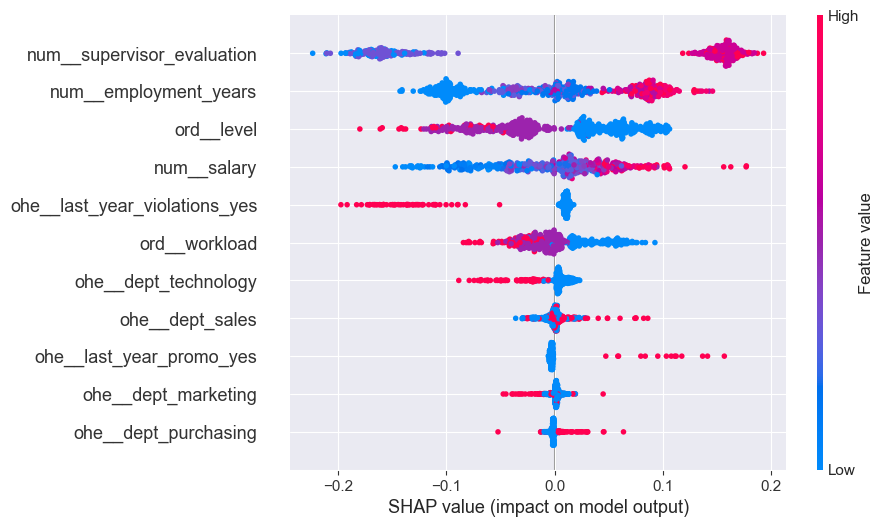

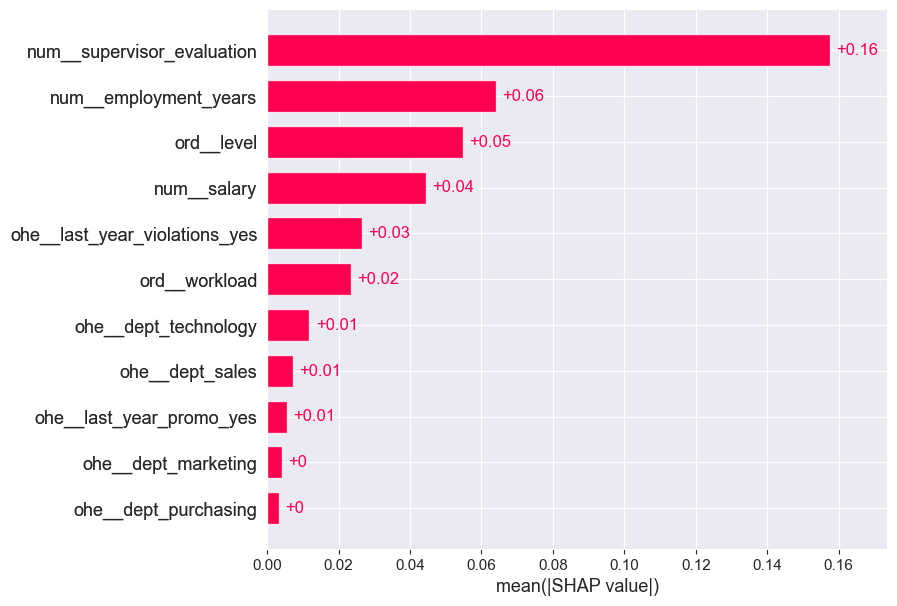

In [37]:
shap.plots.beeswarm(shap_values, max_display=15) 
plt.show()
shap.plots.bar(shap_values, max_display=15)
plt.show()

**Вывод:** методом SHAP установлены наиболее важные для модели признаки:
- `supervisor_evaluation` - лидирует с большим отрывом
- `employment_years`
- `level`
- `salary`
- `last_year_violations`

Для сравнения результатов оценим вклад каждого признака в предсказания модели с помощью встроенного метода **feature_importances_**, доступного для модели дерева решений

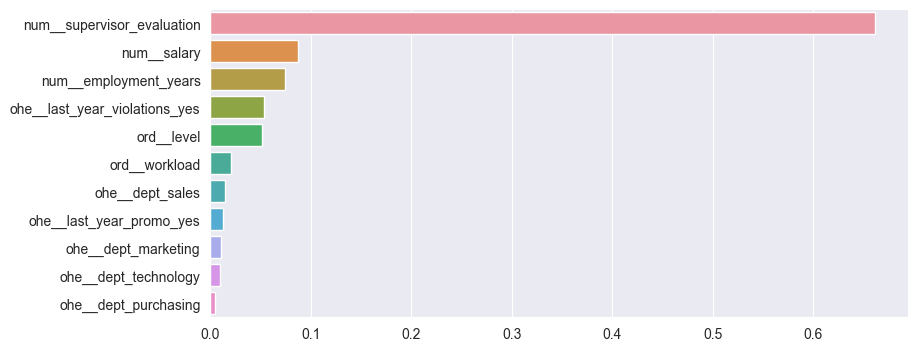

In [38]:
feature_importances = pd.Series(
    randomized_search_1.best_estimator_['models'].feature_importances_, 
    feature_names).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(x=feature_importances, y=feature_importances.index, ax=ax)
plt.show()

**Вывод:** картина, в целом, схожая. Наибольший вклад, как и в предыдущем пункте, вносит признак `supervisor_evaluation` - его отрыв от остальных, при использовании данного способа оценки, еще внушительнее. Топ-5 признаков сохранился, изменился лишь порядок.

### Выводы по первой задаче

В рамках первой части проекты была выполнена поставленная задача, а именно построена модель, которая предсказывает уровень удовлетворённости сотрудника (`job_satisfaction_rate`) на основе данных заказчика.\
Наиболее точной моделью для данной задачи оказалась **DecisionTreeRegressor** с параметрами **'max_features': 13, 'max_depth': 13**. Скорее всего, данная модель оказалась лучшей за счет большего, чем у других, количества гиперпараметров, что позволяет ей быть более гибкой.\
Метрика SMAPE на тренировочной выборке: **15.797**; на тестовой - **14.351**.\
Наиболее значимым признаком для предсказания таргета является: `supervisor_evaluation` - оценка качества работы сотрудника, которую дал руководитель.

## **Задача 2: предсказание увольнения сотрудника из компании**

В рамках второй задачи необходимо построить модель классификации для пре5дсказания бинарного признака `quit` — увольнение сотрудника из компании.\
Входные признаки тестовой выборки те же, что и в прошлой задаче.

### Загрузка данных

In [39]:
try:
    train_quit = pd.read_csv('/datasets/train_quit.csv')
    y_test_quit = pd.read_csv('/datasets/test_target_quit.csv')
except:
    train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv')
    y_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

df_list_2 = [train_quit, y_test_quit]
df_name_2 = ['train_quit', 'y_test_quit']

Вывод первых строк каждой из таблиц и общей информации о данных:

In [40]:
for df, df_name in zip(df_list_2, df_name_2):
    print(f'{df_name}:')
    display(df.head())
    df.info()
    print('\n')

train_quit:


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


y_test_quit:


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB




Проверка наличия пропусков в данных:

In [41]:
for df, df_name in zip(df_list_2, df_name_2):
    print(f'{df_name}:')
    x = df.isna().sum()[df.isna().sum() > 0]
    print('Пропусков нет' if len(x) == 0 else x, '\n')

train_quit:
Пропусков нет 

y_test_quit:
Пропусков нет 



**Вывод:** данные в таблицах соответствуют описанию. Тип данных у всех признаков корректный. Пропуски отсутствуют.

### Предобработка данных

#### Проверка наличия неявных дубликатов

In [42]:
for df, df_name in zip(df_list_2, df_name_2):
    print(f'{df_name}:')
    cat_col_names = df.select_dtypes(include='object').columns.tolist()
    for col in cat_col_names:
        print(f'{col}:', df[col].unique())
    print() 

train_quit:
dept: ['sales' 'purchasing' 'marketing' 'technology' 'hr']
level: ['middle' 'junior' 'sinior']
workload: ['high' 'medium' 'low']
last_year_promo: ['no' 'yes']
last_year_violations: ['no' 'yes']
quit: ['no' 'yes']

y_test_quit:
quit: ['yes' 'no']



#### Проверка наличия явных дубликатов

In [43]:
for i, j in zip(df_list_2, df_name_2):
    print(f'{df_name}:', df.duplicated().sum())

y_test_quit: 0
y_test_quit: 0


**Вывод:** дубликаты в данных отсутствуют.

#### Объединение таблиц **X_test_sat** и **y_test_quit**

По аналогии с первой задачей объединим таблицы тестовой выборки по столбцу `id` методом **inner** и убедимся, что количество строк осталось прежним, т.е. 2000. \
Для начала в качестве индекса установим столбец id во всех датафреймах.

In [44]:
for df in df_list_2:
    df.set_index('id', inplace=True)
    # проверяем результат
    display(df.head(1))

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no


,quit
id,
999029,yes


In [45]:
test_quit = X_test_sat.join(y_test_quit, how='inner')
# проверяем результат
display(test_quit.head())
test_quit.shape

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no
686555,hr,junior,medium,1,no,no,4,30000,no
467458,sales,middle,low,5,no,no,4,19200,no
418655,sales,middle,low,6,no,no,4,19200,no
789145,hr,middle,medium,5,no,no,5,40800,no


(2000, 9)

**Вывод:** в таблицах в качестве индекса установлен столбец id. Объединение X_test_sat и y_test_quit успешно осуществлено. Количество строк равно 2000, как и в исходных таблицах, т.е. непересекающихся значений в данных небыло.

In [46]:
# обновим список датафреймов
df_list_2 = [train_quit, test_quit]
df_name_2 = ['train_quit', 'test_quit']

Вновь проверим данные на наличие явных дубликатов при отсутствие столбца id

In [47]:
for df, df_name in zip(df_list_2, df_name_2):
    print(f'{df_name}:', df.duplicated().sum())

train_quit: 1413
test_quit: 504


**Вывод:** в тренировочной выборке боле 1400 дубликатов. Так же как и в первой задаче перед обучением модели мы их удалим, что бы модель не делала акцент на этих дублирующихся значениях.

### Исследовательский анализ данных

Описательная статистика числовых данных

In [48]:
for df, df_name in zip(df_list_2, df_name_2):
    print(f'{df_name}:')
    display(df.describe())
    print()

train_quit:


,employment_years,supervisor_evaluation,salary
count,4000.000000,4000.000000,4000.000000
mean,3.701500,3.474750,33805.800000
std,2.541852,1.004049,15152.415163
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000



test_quit:


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


**Вывод:** выбросов и аномалий в данных не наблюдается. Распределения значений в тестовой и тренировочной выборках схожи.

#### Распределение числовых признаков

Рассмотрим, как распределены значения числовых признаков в тренировочном и тестовом датафремах с группировкой по целевому признаку `quit`.

In [49]:
# Сформируем списки с числовыми и категориальными признаками
num_col = train_quit.select_dtypes(include='number').columns.tolist()
cat_col = train_quit.select_dtypes(include='object').columns.tolist()

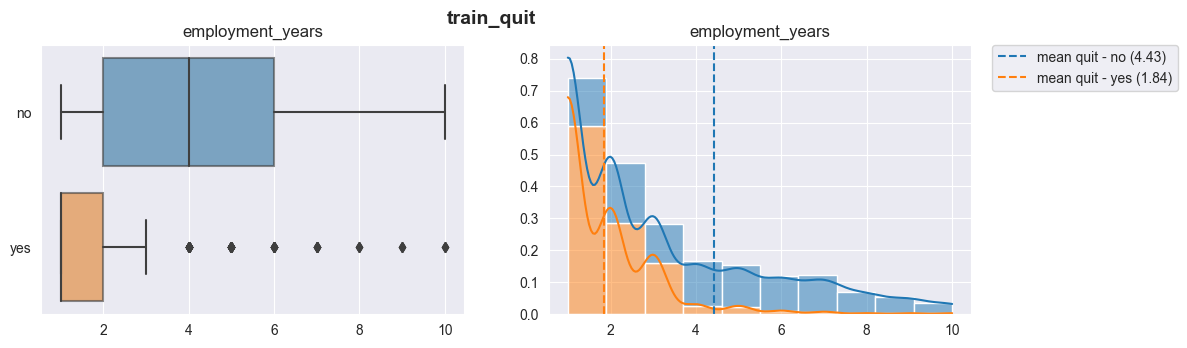

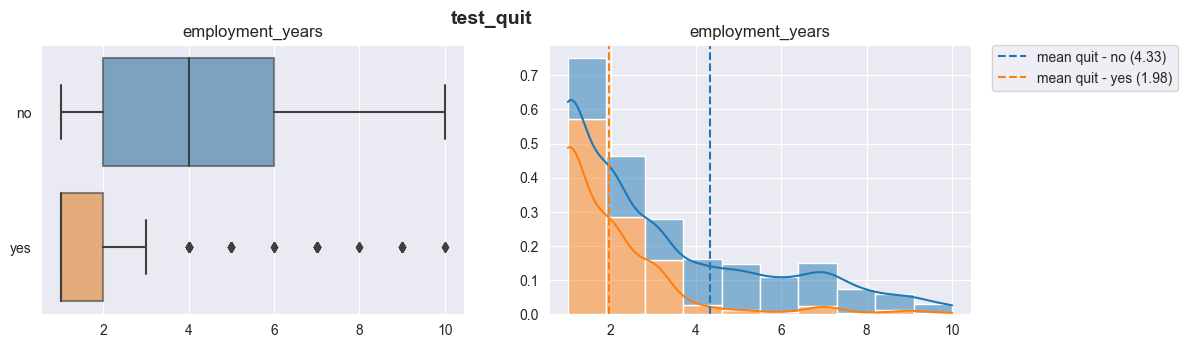

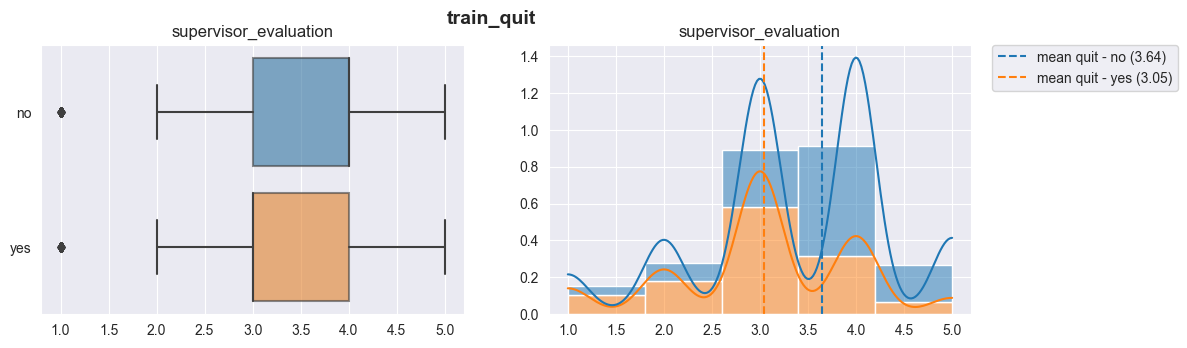

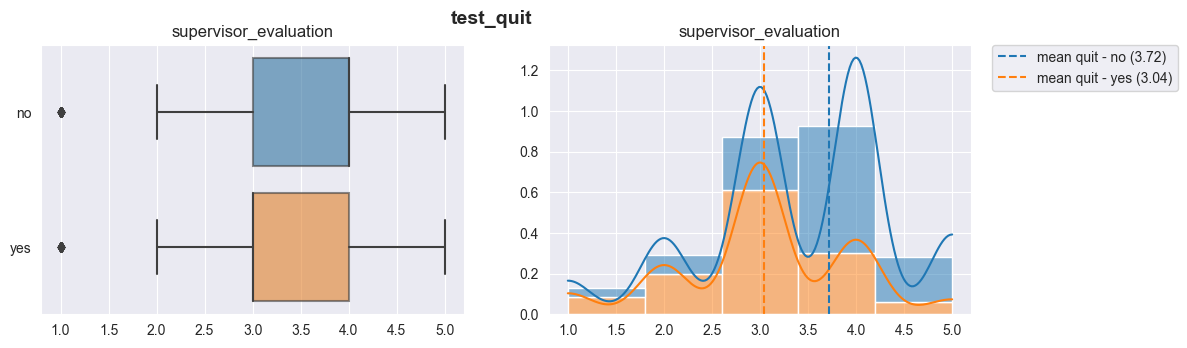

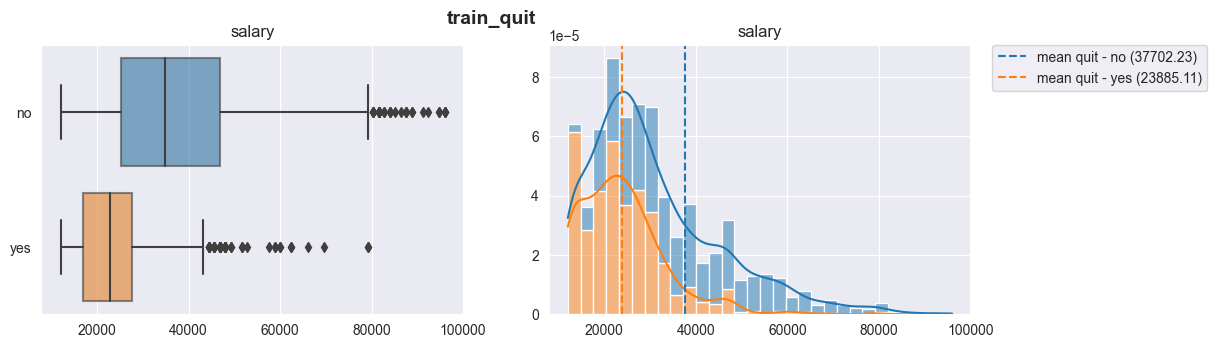

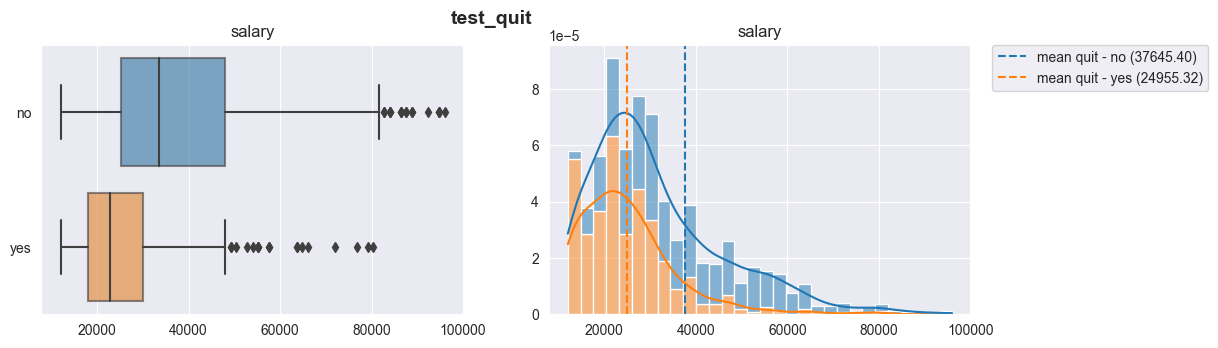

In [50]:
for col in num_col:
    for df, df_name in zip(df_list_2, df_name_2):
        chart_box_hist(df, [col], f'{df_name}', hue='quit')
    print('\n\n\n')

**Вывод:** числовые признаки имеют схожее распределение в тренировочном и тестовом датафреймах.

#### Распределение категориальных признаков

Теперь рассмотрим распределения категориальных признаков, так же с группировкой по `quit`.

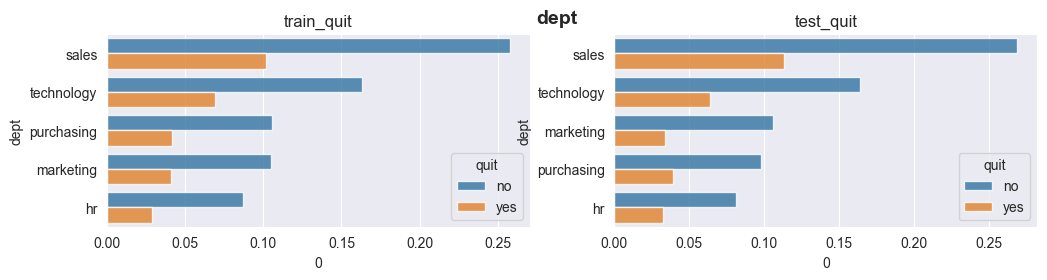

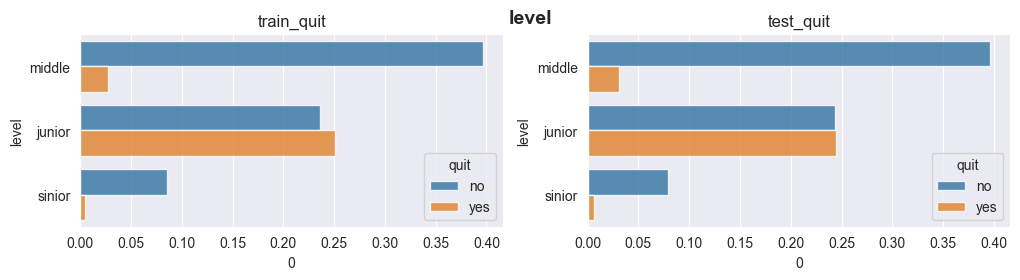

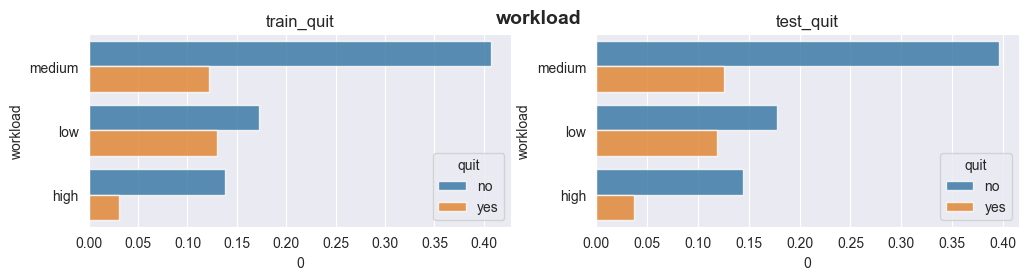

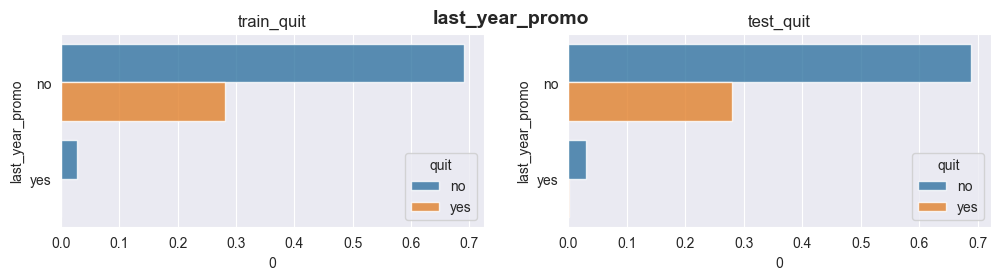

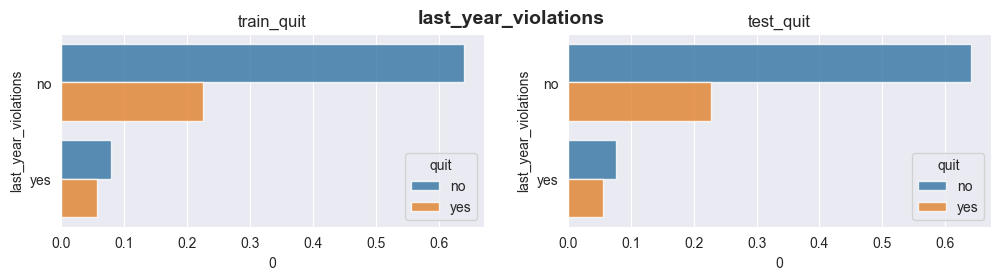

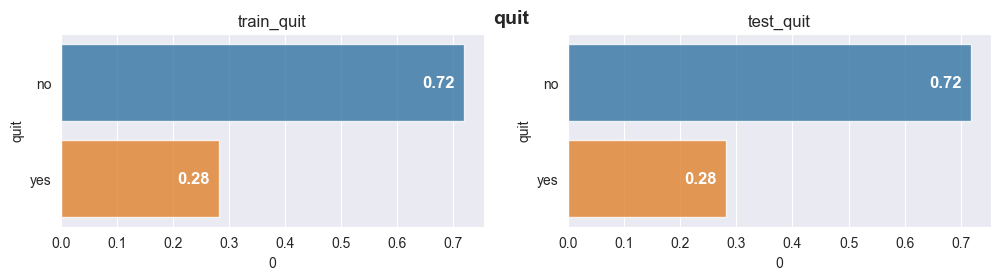

In [51]:
for col in cat_col:
    fig, axes = plt.subplots(1, 2, figsize=(12, 2.5))
    plt.suptitle(col, fontsize=14, fontweight='bold')
    for df, df_name, ax in zip(df_list_2, df_name_2, axes):
        if col != 'quit':
            data = pd.DataFrame(df.value_counts([col, 'quit'], normalize=True)).reset_index()
            data = data[data[col] != ' ']
            sns.barplot(data=data, x=0, y=col, hue='quit', alpha=.8, ax=ax)
        else:
            data = pd.DataFrame(df.value_counts([col], normalize=True)).reset_index()
            g = sns.barplot(data=data, x=0, y='quit', alpha=.8, ax=ax)
            ax.bar_label(g.containers[0], padding=-30, fontsize=12, color='white', fontweight='bold', fmt='%.2f')
        ax.set_title(df_name)
    plt.show()
    print('\n')

**Вывод:** категориальные признаки также распределены похожим образом в тренировочном и тестовом датафреймах.

#### Портрет «уволившегося сотрудника»

In [52]:
# Соединим датафреймы train_quit, test_quit 
# для возможности рассмотреть сразу все имеющиеся данные
data_quit = pd.concat([train_quit, test_quit])

Расчет средней оценки руководителя и ЗП для ушедших и не ушедших:

In [53]:
data_quit.pivot_table(columns='quit', values=['supervisor_evaluation', 'salary']).round(1)

quit,no,yes
salary,37683.3,24241.8
supervisor_evaluation,3.7,3.0


Для каждой категориальной категории расчитаем долю ушедших сотрудников и изобразим ее на графиках

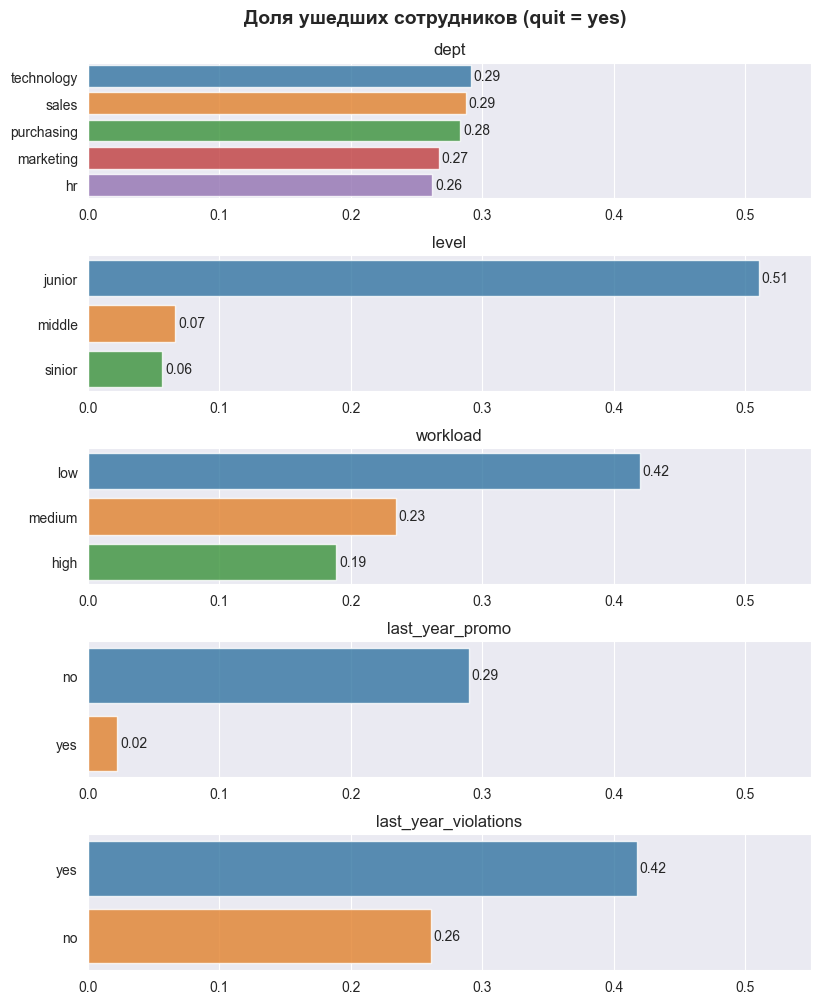

In [54]:
fig, axes = plt.subplots(5, 1, figsize=(8, 10))
plt.suptitle('Доля ушедших сотрудников (quit = yes)', fontsize=14, fontweight='bold', y=1)
fig.tight_layout(h_pad=2)
for col, ax in zip(cat_col[:5], axes.flat):
    data_quit = data_quit[data_quit[col] != ' ']
    df_pivot = data_quit.pivot_table(index=col, columns='quit',aggfunc={col:'count'})
    df_pivot = df_pivot.div(df_pivot.sum(axis=1), axis=0)
    
    df_pivot.columns = df_pivot.columns.droplevel()
    df_pivot = df_pivot.sort_values('yes', ascending=False)

    g = sns.barplot(y=df_pivot.index, x=df_pivot['yes'], alpha=.8, ax=ax)
    ax.bar_label(g.containers[0], padding=2, fmt='%.2f')
    ax.set(title=col, xlabel='', ylabel='')
    ax.set_xlim(0, .55)
    
plt.show()

Доля всех уволившихся сотрудников составляет **28%**.

Исходя из вышеприведенных графиков можно сделать следующие выводы относительно большинства уволившихся сотрудников:
- обладают более низкими оценками от руководителя - в среднем около **3** (тогда как у не ушедших в районе **3.7**).
- получают меньшую ЗП - в среднем **24 241**, что **на 13 441 меньше**, чем у не ушедших.
- в основном занимают позиции джуниуров. Среди всех джуниуров доля уволившихся составляет **51%** - каждый второй джун не дожидается повышения.
- имеют низкую загруженность. Среди всех низкозагруженных сотрудников увольняются **42%**.
- не получали повышения за последний год. Среди не получавших повышение увольняется **29%** сотрудников.
- нарушение трудового договора за последний год так же повышает шанс увольнения. Среди нарушающих - **42%** увольняются.
- а вот отдел, в котором работает сотрудник, практически не влияет на вероятность увольнения. Чаще всего увольняются из `technology` и `sales` - в **29%** случаев. Реже всего из `hr` - в **26%**.

#### Связь уровня удовлетворённости сотрудника работой в компании и факта увольнения

Аналитики утверждают, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник. Проверим это утверждение, для этого добавим `job_satisfaction_rate_pred`, предсказанный лучшей моделью первой задачи, ко входным признакам второй задачи.

In [55]:
train_quit['job_satisfaction_rate_pred'] = randomized_search_1.predict(train_quit)
test_quit['job_satisfaction_rate_pred'] = randomized_search_1.predict(test_quit)

# Проверка результата
display(train_quit.head())
test_quit.head()

C:\Users\johnny\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.660000
814010,sales,junior,medium,2,no,no,4,27600,no,0.853529
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.364091
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.380000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.690000


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate_pred
id,,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,no,0.863333
686555,hr,junior,medium,1,no,no,4,30000,no,0.670417
467458,sales,middle,low,5,no,no,4,19200,no,0.654000
418655,sales,middle,low,6,no,no,4,19200,no,0.655000
789145,hr,middle,medium,5,no,no,5,40800,no,0.824643


Признак `job_satisfaction_rate_pred` успешно добавлен.

Рассмотрим коэффициент корреляции фи между `quit` и `job_satisfaction_rate_pred`.

In [56]:
interval_cols = ['employment_years', 'salary', 'job_satisfaction_rate_pred']
phik_overview_1 = train_quit.phik_matrix(interval_cols=interval_cols)
phik_overview_2 = test_quit.phik_matrix(interval_cols=interval_cols)

print(f'Коэффициент корреляции фи между quit и job_satisfaction_rate_pred:')
print(f"- train: {phik_overview_1.loc['quit', 'job_satisfaction_rate_pred']:.3f}")
print(f"- test:  {phik_overview_2.loc['quit', 'job_satisfaction_rate_pred']:.3f}")

Коэффициент корреляции фи между quit и job_satisfaction_rate_pred:
- train: 0.523
- test:  0.568


**Вывод:** между `quit` и `job_satisfaction_rate_pred` наблюдается заметная связь.

Построим диаграммы рассеяния для признака `job_satisfaction_rate_pred` относительно других числовых признаков, группирую значения по признаку `quit`:

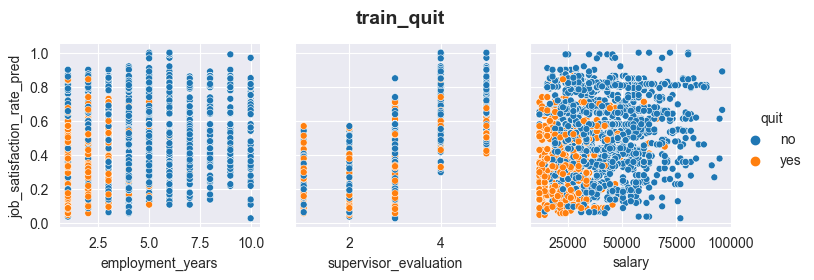

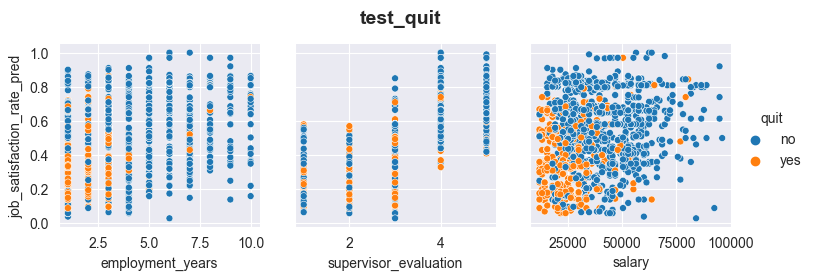

In [57]:
for df, df_name in zip(df_list_2, df_name_2):
    g = sns.PairGrid(
        df, 
        x_vars=num_col, 
        y_vars='job_satisfaction_rate_pred',
        hue='quit'
    )
    g.map_offdiag(sns.scatterplot, s=25)
    g.add_legend()
    g.fig.suptitle(df_name, fontsize=14, fontweight='bold', y=1.08)
    plt.show()
    print('\n')

**Вывод:** на графиках прослеживается связь между уровнем удовлетворённости сотрудника работой в компании и фактом увольнения.

#### Корреляционный анализ

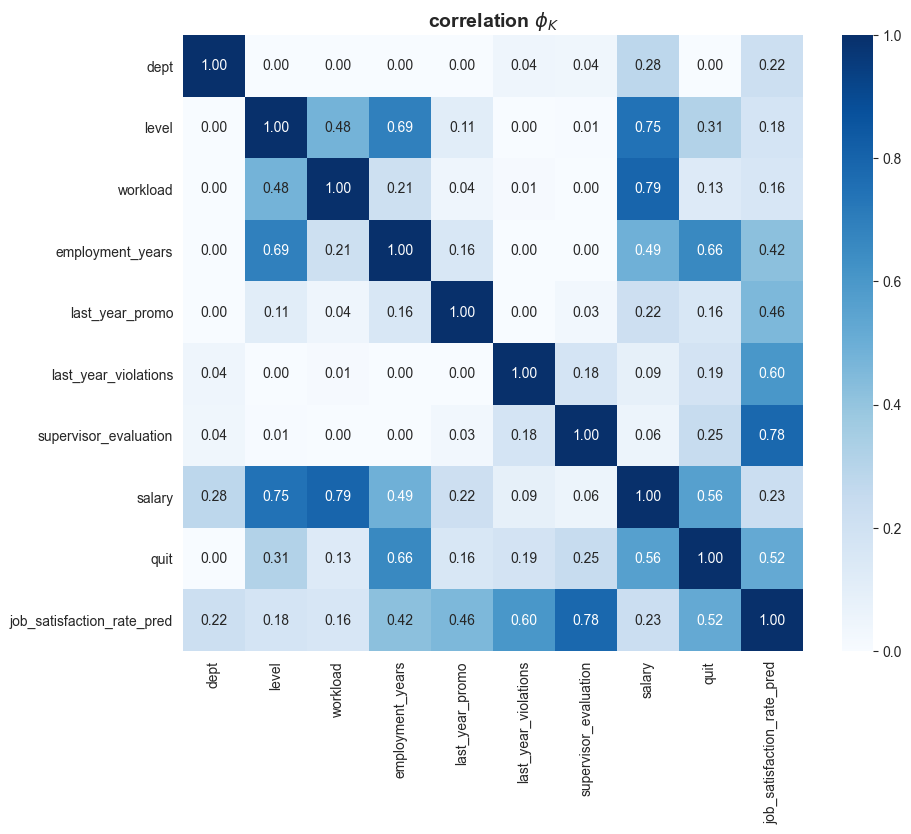

Наибольшие коэффициенты корреляции:


,feature_1,feature_2,corr
0,salary,workload,0.793876
1,supervisor_evaluation,job_satisfaction_rate_pred,0.783029
2,salary,level,0.745104
3,level,employment_years,0.692676
4,quit,employment_years,0.659093
5,last_year_violations,job_satisfaction_rate_pred,0.603494
6,salary,quit,0.564154
7,quit,job_satisfaction_rate_pred,0.522514
8,employment_years,salary,0.491915
9,level,workload,0.479480


In [58]:
corr_matrix(phik_overview_1)

print('Наибольшие коэффициенты корреляции:')
corr_sort(phik_overview_1).head(10)

Рассмотрим отдельно корреляцию целевого признака

In [59]:
target_corr(phik_overview_1, 'quit')

,коэффициент корреляции,тип связи
employment_years,0.659093,заметная
salary,0.564154,заметная
job_satisfaction_rate_pred,0.522514,заметная
level,0.312799,умеренная
supervisor_evaluation,0.245489,слабая
last_year_violations,0.185071,слабая
last_year_promo,0.157370,слабая
workload,0.132243,слабая
dept,0.000000,осутствует


**Вывод:** мультиколлинеорность у признаков отсутствует (коэффициент выше 0.95). \
Таргет `quit` имеет наибольшую взаимосвязь с такими признаками, как `employment_years`, `salary` и `job_satisfaction_rate_pred`.

Сравним распределения уровня удовлетворённости сотрудника работой в компании (`job_satisfaction_rate_pred`) для ушедших и оставшихся работников

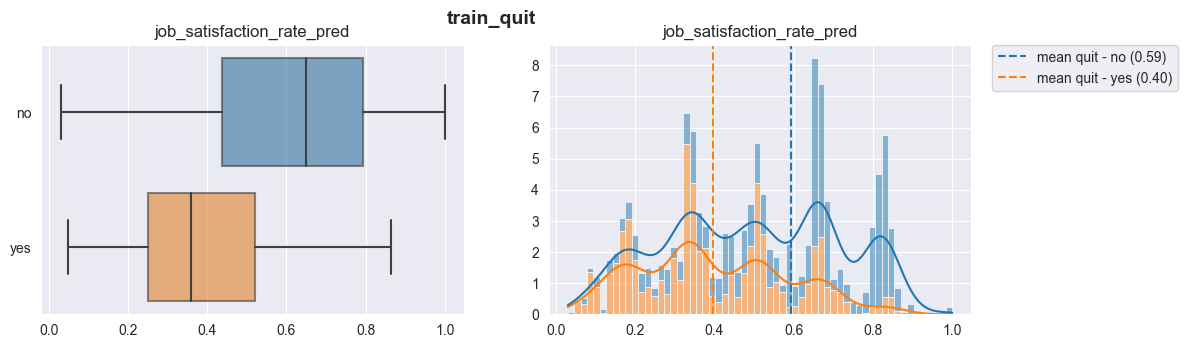

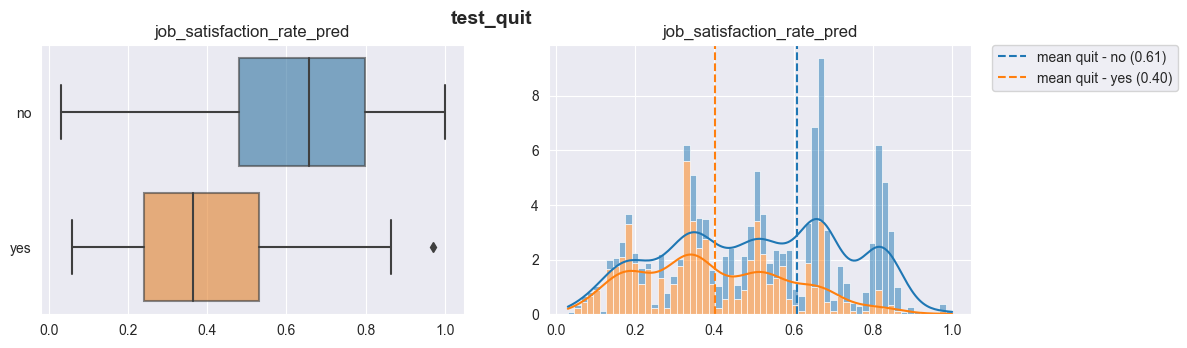

In [60]:
for df, df_name in zip(df_list_2, df_name_2):
    chart_box_hist(df, ['job_satisfaction_rate_pred'], f'{df_name}', hue='quit', bins=60)

**Вывод:** на графиках видно, что уровень удоветворенности уволившихся сотрудников в среднем ниже на **20%**, чем у оставшихся.

### Подготовка данных

В тренировочном датасете удалим дубликаты строк, что бы модель не усиливала взаимосвязи, присущие дублирующимся строкам.

In [61]:
print('Количество дубликатов в train_sat:', train_quit.duplicated().sum())

rows_before = train_quit.shape[0]

train_quit.drop_duplicates(inplace=True)

# проверка
print('Количество удаленных строк:', rows_before - train_quit.shape[0])

Количество дубликатов в train_sat: 1413
Количество удаленных строк: 1413


1413 дубликатов успешно удалены.

In [62]:
print('Размеры исходных датафреймов:')
print(f'train_quit: {train_quit.shape}')
print(f'test_quit: {test_quit.shape}')

Размеры исходных датафреймов:
train_quit: (2587, 10)
test_quit: (2000, 10)


Каждый датафрейм разделим на два, отделив таргет

In [63]:
target = 'quit'

X_train = train_quit.drop(target, axis=1)
y_train = train_quit[target]

X_test = test_quit.drop(target, axis=1)
y_test = test_quit[target]

# закодируем целевой признак
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'supervisor_evaluation', 'job_satisfaction_rate_pred']

print('Размеры датафреймов после отделения таргета:')
print(f'X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}, y_test: {y_test.shape}')

Размеры датафреймов после отделения таргета:
X_train: (2587, 9), y_train: (2587,)
X_test: (2000, 9), y_test: (2000,)


**Вывод:** данные успешно подготовлены. Количество элементов в разделенных датафремах в сумме совпадает с количеством в исходных.

Финальная подготовка данных будет осуществляться в том же пайплане, который мы использовали в первой задаче.

### Обучение моделей

На этот раз целевой признак - категориальный, поэтому для обучения будем использовать несколько моделей классификации - **KNeighborsClassifier**, **DecisionTreeClassifier**, **LogisticRegression**, **SVC**.

In [64]:
param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 30) 
    },
    
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__max_features': range(2, 10)
    },
    
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 10)
    },

    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],
        'models__kernel': ['linear', 'rbf'],
        'models__C': np.arange(.1, 4, .2)
    }
]

#randomized_search_2 = GridSearchCV(
randomized_search_2 = RandomizedSearchCV(
    pipline_final(ohe_columns, ord_columns, num_columns), 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1, 
    random_state=RANDOM_STATE,
    n_iter=50
)

# Обучаем лучшую модель на тренировочных данных
randomized_search_2.fit(X_train, y_train)


print(f'Лучшая модель и её параметры:\n {randomized_search_2.best_params_}')
print(f'Метрика ROC-AUC на тренировочной выборке: {randomized_search_2.best_score_:.3f}')

y_test_pred_proba = randomized_search_2.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba):.3f}')

Лучшая модель и её параметры:
 {'models__n_neighbors': 29, 'models': KNeighborsClassifier()}
Метрика ROC-AUC на тренировочной выборке: 0.906
Метрика ROC-AUC на тестовой выборке: 0.909


C:\Users\johnny\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Рассмотрим список из 5 лучших моделей

In [65]:
cv_results_best(randomized_search_2).head()

,mean_test_score,params
rank_test_score,,
1,0.906309,"{'models__n_neighbors': 29, 'models': KNeighborsClassifier()}"
2,0.906068,"{'models__n_neighbors': 27, 'models': KNeighborsClassifier()}"
3,0.905895,"{'models__n_neighbors': 28, 'models': KNeighborsClassifier()}"
4,0.905196,"{'models__n_neighbors': 26, 'models': KNeighborsClassifier()}"
5,0.904477,"{'models__n_neighbors': 20, 'models': KNeighborsClassifier()}"


**Вывод:** лучшей моделью оказалась **KNeighborsClassifier** с параметрами **'n_neighbors': 29**.\
Метрика ROC-AUC на тренировочной выборке: **0.906**; на тестовой - **0.909**.

Попробуем улучшить модель, отобрав наиболее важные признаки, для этого оценим их важность с помощью метода SHAP.

In [66]:
feature_names = randomized_search_2.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
X_test_transform = randomized_search_2.best_estimator_.named_steps['preprocessor'].transform(X_test)

# отберем 100 наблюдений, что бы сократить время ожидания выполнения кода
X_test_transform_sample = shap.sample(X_test_transform, 100, random_state=RANDOM_STATE)

explainer = shap.Explainer(randomized_search_2.best_estimator_['models'].predict, X_test_transform, feature_names=feature_names)
shap_values = explainer(X_test_transform_sample)

C:\Users\johnny\anaconda3\envs\practicum\lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
PermutationExplainer explainer: 101it [01:42,  1.13s/it]                                                               


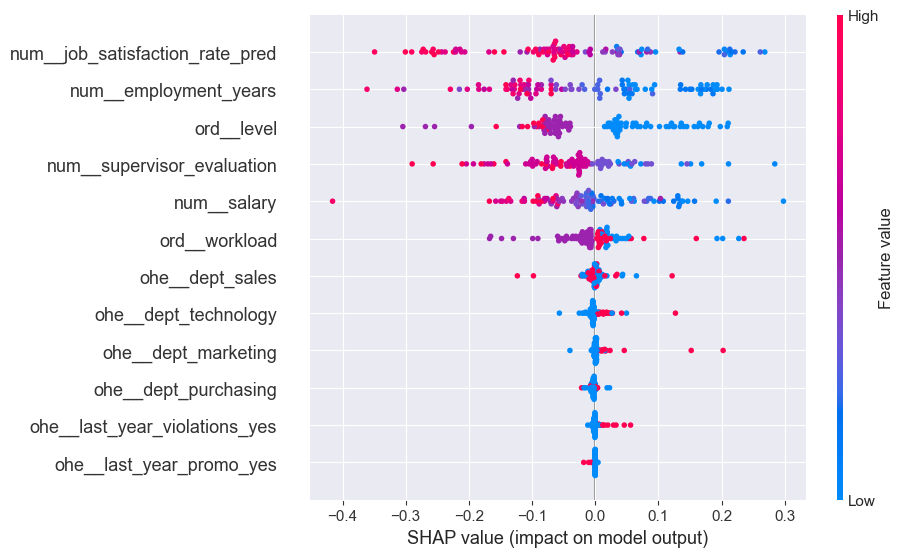

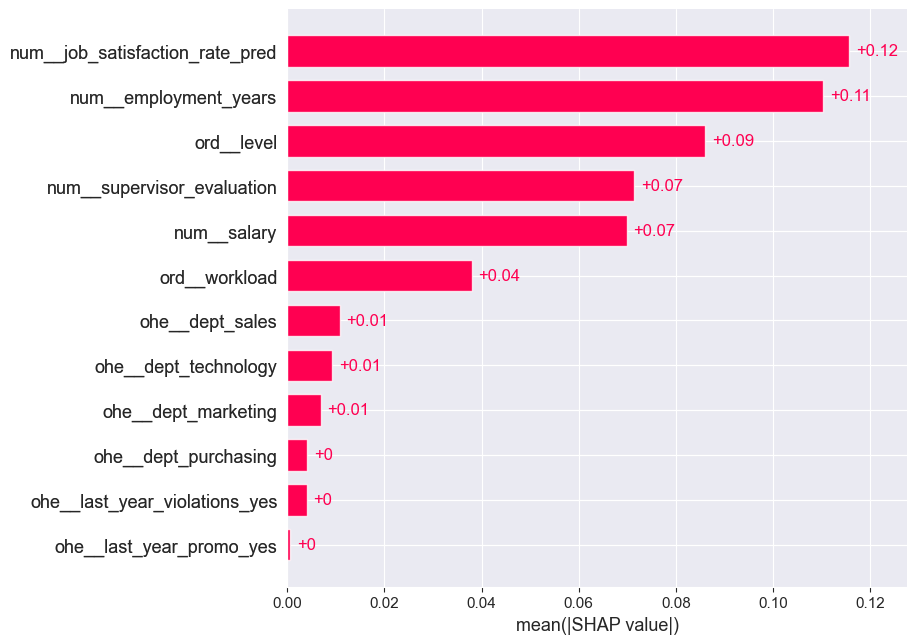

In [67]:
shap.plots.beeswarm(shap_values, max_display=15) 
plt.show()
shap.plots.bar(shap_values, max_display=15)
plt.show()

Для обучения новой модели будем использовать только следующие признаки: `job_satisfaction_rate_pred`, `employment_years`, `level`, `salary`, `supervisor_evaluation`, `workload`.\
В переборе параметров оставим только лучшую модель **KNeighborsClassifier**, перебор параметров в этот раз будем осуществлять по сетке.

In [68]:
ohe_columns = []
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'salary', 'job_satisfaction_rate_pred', 'supervisor_evaluation']

param_grid = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 30) 
    }
]

grid_search_2 = GridSearchCV(
    pipline_final(ohe_columns, ord_columns, num_columns), 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

# Обучаем лучшую модель на тренировочных данных
grid_search_2.fit(X_train, y_train)


print(f'Лучшая модель и её параметры:\n {grid_search_2.best_params_}')
print(f'Метрика ROC-AUC на тренировочной выборке: {grid_search_2.best_score_:.3f}')

y_test_pred_proba = grid_search_2.predict_proba(X_test)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred_proba):.3f}')

Лучшая модель и её параметры:
 {'models': KNeighborsClassifier(), 'models__n_neighbors': 28}
Метрика ROC-AUC на тренировочной выборке: 0.913
Метрика ROC-AUC на тестовой выборке: 0.918


In [69]:
cv_results_best(grid_search_2).head()

,mean_test_score,params
rank_test_score,,
1,0.912798,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 28}"
2,0.912780,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 29}"
3,0.912670,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 22}"
4,0.912194,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 21}"
5,0.911974,"{'models': KNeighborsClassifier(), 'models__n_neighbors': 27}"


**Вывод:** сокращение количества признаков позволило улучшить метрику ROC-AUC, и теперь она на тренировочной выборке составляет: **0.913**; на тестовой - **0.918**.\
Лучшей моделью оказалась **KNeighborsClassifier** с параметрами **'n_neighbors': 28**. Данная модель может показывать хорошую точность при работе с нелинейными данными, возможно в нашем случае это и стало причиной того, что она оказалась самой точной.

Наиболее важными для модели признаками являются:
- `job_satisfaction_rate_pred`
- `employment_years`
- `level`
- `supervisor_evaluation`
- `salary`
- `workload`

## Общий вывод

**Поставленная задача:** построить две модели, одна из которых должна предсказывать уровень удовлетворённости сотрудника, а вторая - факт того, что сотрудник уволится из компании.
<br><br>

**Лучшие модели:**
1. *Для первой задачи:* **DecisionTreeRegressor** с параметрами **'max_features': 13, 'max_depth': 13**. Метрика SMAPE на тренировочной выборке: `15.797`; на тестовой - `14.351`.
2. *Для второй задачи:* **KNeighborsClassifier** с параметрами **'n_neighbors': 28**. Метрика ROC-AUC на тренировочной выборке: `0.913`; на тестовой - `0.918`.
<br><br>

**В рамках каждой задачи было выполнено следующее:**
1. Загрузка и первичное изучение данных.
2. Предобработка данных, в ходе которой осуществлялся поиск дубликатов и объединение таблиц.
3. Исследовательский анализ данных, в ходе которого было рассмотрено распределение количественных и категориальных признаков в тренировочных и тестовых данных. А так же произведен корреляционный анализ данных.
4. Финальная подготовка данных с помощью пайплайна.
5. Обучение нескольких моделей с подбором гиперпараметров и выбор лучшей с применением кроссвалидации
6. Анализ важности признаков.
<br><br>

**Предложение для бизнеса**, которое поможет уменьшить вероятность увольнения сотрудника и повысить его уровень удовлетворенности работой в компании: дать сотруднику возможность более быстрого перехода с должности джуниура, что в свою очередь позволит ему решать более широкий спектр задач - это повысит его загруженность и даст возможность получать более высокую ЗП.